In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [2]:
data = pd.read_csv('input_data/KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')


In [70]:
data['koi_disposition'].value_counts()

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

In [3]:
(data[data['koi_disposition'] == 'CANDIDATE']['koi_score'] > 0.95).sum()

747

In [4]:
data['ExoplanetCandidate'] = data['koi_disposition'].apply(lambda x: 1 if x == 'CANDIDATE' or x == 'CONFIRMED' else 0)


In [5]:
# Load and preprocess data
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = data[short_cols].dropna()
data.to_csv('output_data/KOI_2025.07.31_cleaned.csv')

# Prepare features and target
X = data.drop(columns=['ExoplanetCandidate'])
y = data['ExoplanetCandidate']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2, stratify=y)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
joblib.dump(scaler, 'output_data/scaler_ksmet.sav')

['output_data/scaler_ksmet.sav']

In [6]:
model_dir = 'models/'

# 1. LogisticRegression

In [10]:
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'l1_ratio': np.linspace(0, 1, 5)  # Only used when penalty='elasticnet'
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,             # use all CPU cores
    verbose=1
)

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Suppress all sklearn UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
# Train (fit) the grid search
grid.fit(X_train, y_train)

# -----------------------------
# Results
# -----------------------------

# 1. Best parameters
print("Best parameters:", grid.best_params_)

# 2. Best mean CV score
print("Best mean CV accuracy:", grid.best_score_)

# 3. The best estimator (trained on all training data)
best_model_lr = grid.best_estimator_

# 4. Predictions on test set
y_pred_lr = best_model_lr.predict(X_test)

# 5. Detailed results for each parameter combination
results_df_lr = pd.DataFrame(grid.cv_results_)
print(results_df_lr[['params', 'mean_test_score', 'std_test_score']])
results_df_lr.to_csv(f'{model_dir}/grid_search_results_lr.csv', index=False)

# Save the best model
joblib.dump(best_model_lr, f'{model_dir}/best_model_lr.sav')

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best parameters: {'C': 21.54434690031882, 'l1_ratio': 0.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best mean CV accuracy: 0.787249570135201
                                                params  mean_test_score  \
0    {'C': 0.0001, 'l1_ratio': 0.0, 'penalty': 'l1'...         0.497004   
1    {'C': 0.0001, 'l1_ratio': 0.0, 'penalty': 'l1'...         0.501634   
2    {'C': 0.0001, 'l1_ratio': 0.0, 'penalty': 'l1'...              NaN   
3    {'C': 0.0001, 'l1_ratio': 0.0, 'penalty': 'l2'...         0.734131   
4    {'C': 0.0001, 'l1_ratio': 0.0, 'penalty': 'l2'...         0.728137   
..                                                 ...              ...   
595  {'C': 10000.0, 'l1_ratio': 1.0, 'penalty': 'el...         0.783435   
596  {'C': 10000.0, 'l1_ratio': 1.0, 'penalty': 'el...              NaN   
597  {'C': 10000.0, 'l1_ratio': 1.0, 'penalty': 'no...              NaN   
598  {'C': 10000.0, 'l1_ratio': 1.0, 'penalty'

['models//best_model_lr.sav']

# 2. KNeighborsClassifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': list(range(1, 31, 2)),  # odd numbers 1,3,5,...,29
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'leaf_size': [20, 30, 40]
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


In [13]:
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

best_model_knc = grid.best_estimator_

y_pred_knc = best_model_knc.predict(X_test)

results_df_knc = pd.DataFrame(grid.cv_results_)
print(results_df_knc[['params', 'mean_test_score', 'std_test_score']])
results_df_knc.to_csv(f'{model_dir}/grid_search_results_knc.csv', index=False)

joblib.dump(best_model_knc, f'{model_dir}/best_model_knc.sav')

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best params: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Best score: 0.785069826366154
                                                params  mean_test_score  \
0    {'algorithm': 'auto', 'leaf_size': 20, 'n_neig...         0.757421   
1    {'algorithm': 'auto', 'leaf_size': 20, 'n_neig...         0.757421   
2    {'algorithm': 'auto', 'leaf_size': 20, 'n_neig...         0.750202   
3    {'algorithm': 'auto', 'leaf_size': 20, 'n_neig...         0.750202   
4    {'algorithm': 'auto', 'leaf_size': 20, 'n_neig...         0.775672   
..                                                 ...              ...   
715  {'algorithm': 'brute', 'leaf_size': 40, 'n_nei...         0.777442   
716  {'algorithm': 'brute', 'leaf_size': 40, 'n_nei...         0.774720   
717  {'algorithm': 'brute', 'leaf_size': 40, 'n_nei...         0.780984   
718  {'algorithm': 'brute', 'leaf_size': 40, 'n_nei...

['models//best_model_knc.sav']

# 3. Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


In [15]:
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

best_model_dtc = grid.best_estimator_

y_pred_dtc = best_model_dtc.predict(X_test)

results_df_dtc = pd.DataFrame(grid.cv_results_)
print(results_df_dtc[['params', 'mean_test_score', 'std_test_score']])
results_df_dtc.to_csv(f'{model_dir}/grid_search_results_dtc.csv', index=False)

joblib.dump(best_model_dtc, f'{model_dir}/best_model_dtc.sav')

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best score: 0.8119015512230048
                                                params  mean_test_score  \
0    {'criterion': 'gini', 'max_depth': None, 'max_...         0.776079   
1    {'criterion': 'gini', 'max_depth': None, 'max_...         0.775673   
2    {'criterion': 'gini', 'max_depth': None, 'max_...         0.779759   
3    {'criterion': 'gini', 'max_depth': None, 'max_...         0.783164   
4    {'criterion': 'gini', 'max_depth': None, 'max_...         0.776626   
..                                                 ...              ...   
763  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.787521   
764  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.795015   
765  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.795015   
766  {'criterion': 'entropy', 'm

['models//best_model_dtc.sav']

# 4. Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_model_rf = grid.best_estimator_

y_pred_rf = best_model_rf.predict(X_test)

results_df_rf = pd.DataFrame(grid.cv_results_)
print(results_df_rf[['params', 'mean_test_score', 'std_test_score']])
results_df_rf.to_csv(f'{model_dir}/grid_search_results_rf.csv', index=False)

joblib.dump(best_model_rf, f'{model_dir}/best_model_rf.sav')


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV accuracy: 0.8379158373877577
                                                 params  mean_test_score  \
0     {'bootstrap': True, 'criterion': 'gini', 'max_...              NaN   
1     {'bootstrap': True, 'criterion': 'gini', 'max_...              NaN   
2     {'bootstrap': True, 'criterion': 'gini', 'max_...              NaN   
3     {'bootstrap': True, 'criterion': 'gini', 'max_...              NaN   
4     {'bootstrap': True, 'criterion': 'gini', 'max_...              NaN   
...                                                 ...              ...   
1291  {'bootstrap': False, 'criterion': 'entropy', '...         0.836554   
1292  {'bootstrap': False, 'criterion': 'entropy', '...         0.836690   
1293  {'bootstrap': False, 'criterion': 'entro

['models//best_model_rf.sav']

# 5. Transformer Neural Network

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn import metrics
from tensorflow.keras import layers

In [38]:
# Transformer Encoder Definition
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Normalization and Multi-Head Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

In [10]:
# Reshape Data for Transformer (3D Input)
x_train = tf.expand_dims(X_train, axis=-1)  # Shape: (batch_size, num_features, 1)
x_test = tf.expand_dims(X_test, axis=-1)

# Build Model with Transformer Encoder and Dense Layers
input_shape = (X_train.shape[1], 1)  # num_features, 1

In [40]:
inputs = layers.Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
x = layers.Flatten()(x)  # Flatten Transformer Output
x = layers.Dense(32)(x)
x = layers.LayerNormalization(axis=-1, center=True, scale=True)(x)
x = layers.Dense(16, activation='relu')(x)  # Used to be ReLU
x = layers.Dense(8, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [51]:
model_tnn = tf.keras.Model(inputs, outputs)

learning_rate = 0.0001  # Default, or try 0.0005 for finer tuning
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

# Compile with the custom optimizer
model_tnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_tnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       449         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Reset model weights
model_tnn.set_weights([np.random.permutation(w.flat).reshape(w.shape) for w in model_tnn.get_weights()])

# Train Model, set early stopping and patience
fitModel = model_tnn.fit(
    x_train, y_train,
    epochs=500, batch_size=8,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]
)

# Save History for Plotting
history = fitModel.history

model_tnn.save(f'{model_dir}/NNmodel.h5')

# Evaluate the model
test_loss, test_accuracy = model_tnn.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/500
918/918 [==============================] - 1s 950us/step - loss: 1.2427 - accuracy: 0.5444 - val_loss: 0.9200 - val_accuracy: 0.5904
Epoch 2/500
918/918 [==============================] - 1s 804us/step - loss: 0.8044 - accuracy: 0.6133 - val_loss: 0.6772 - val_accuracy: 0.6520
Epoch 3/500
918/918 [==============================] - 1s 778us/step - loss: 0.6604 - accuracy: 0.6566 - val_loss: 0.5925 - val_accuracy: 0.7042
Epoch 4/500
918/918 [==============================] - 1s 819us/step - loss: 0.5993 - accuracy: 0.6938 - val_loss: 0.5513 - val_accuracy: 0.7304
Epoch 5/500
918/918 [==============================] - 1s 867us/step - loss: 0.5637 - accuracy: 0.7159 - val_loss: 0.5271 - val_accuracy: 0.7440
Epoch 6/500
918/918 [==============================] - 1s 861us/step - loss: 0.5398 - accuracy: 0.7287 - val_loss: 0.5101 - val_accuracy: 0.7549
Epoch 7/500
918/918 [==============================] - 1s 813us/step - loss: 0.5230 - accuracy: 0.7412 - val_loss: 0.4972 - val_ac

In [56]:
#save history
joblib.dump(history, f'{model_dir}/nn_history.sav')

['models//nn_history.sav']

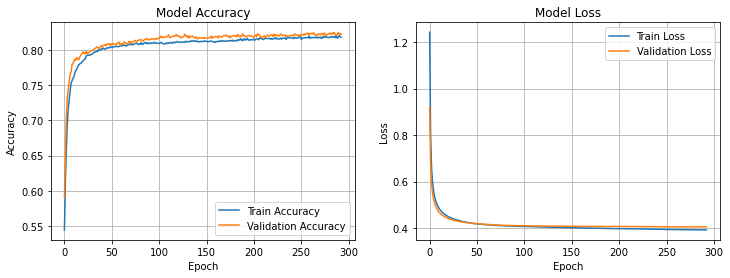

In [53]:
# plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

58/58 [==============================] - 0s 891us/step


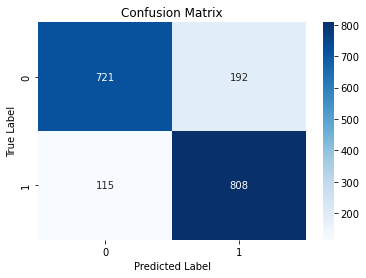

In [45]:
# plot confusion matrix
y_pred = (model_tnn.predict(x_test) > 0.5).astype("int32")
confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6 XGBoost

In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

param_grid = {
    'max_depth': np.linspace(3, 10, 8, dtype=int),  # Depth of each tree
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**base_params),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model_xgb = grid_search.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)

results_df_xgb = pd.DataFrame(grid_search.cv_results_)
print(results_df_xgb[['params', 'mean_test_score', 'std_test_score']])
results_df_xgb.to_csv(f'{model_dir}/grid_search_results_xgb.csv', index=False)

import joblib
joblib.dump(best_model_xgb, f'{model_dir}/best_model_xgb.sav')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.8}
Best cross-validation accuracy: 0.8430938765365232
                                                params  mean_test_score  \
0    {'colsample_bytree': 0.7, 'eta': 0.01, 'max_de...         0.806999   
1    {'colsample_bytree': 0.7, 'eta': 0.01, 'max_de...         0.804956   
2    {'colsample_bytree': 0.7, 'eta': 0.01, 'max_de...         0.804275   
3    {'colsample_bytree': 0.7, 'eta': 0.01, 'max_de...         0.820891   
4    {'colsample_bytree': 0.7, 'eta': 0.01, 'max_de...         0.820074   
..                                                 ...              ...   
211  {'colsample_bytree': 1.0, 'eta': 0.3, 'max_dep...         0.833558   
212  {'colsample_bytree': 1.0, 'eta': 0.3, 'max_dep...         0.835873   
213  {'colsample_bytree': 1.0, 'eta': 0.3, 'max_dep...         0.828247   
214  {'colsample_bytree': 1.0, 'eta': 0.3, 'ma

['models//best_model_xgb.sav']

# 6 Get the best-performing model

In [11]:
best_model_lr = joblib.load(f'{model_dir}/best_model_lr.sav')
best_model_knc = joblib.load(f'{model_dir}/best_model_knc.sav')
best_model_dtc = joblib.load(f'{model_dir}/best_model_dtc.sav')
best_model_rf = joblib.load(f'{model_dir}/best_model_rf.sav')
best_model_tnn = tf.keras.models.load_model(f'{model_dir}/NNmodel.h5')

models = {
    'Logistic Regression': best_model_lr,
    'K-Nearest Neighbors': best_model_knc,
    'Decision Tree': best_model_dtc,
    'Random Forest': best_model_rf,
    'Transformer Neural Network': best_model_tnn
}

# Compare models, and save the best model
from sklearn.metrics import accuracy_score
print("\nModel Performance on Test Set:")
best_model_name = None
best_model_score = 0.0
best_model = None
from sklearn.metrics import accuracy_score  
for name, model in models.items():
    if name == 'Transformer Neural Network':
        y_pred = (model.predict(x_test) > 0.5).astype("int32")
    else:
        y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    # print precision, recall, accuracy, and F1-score to the third decimal place, as well as the confusion matrix components (TN, FP, FN, TP)
    print(f"{name} - Test Accuracy: {score:.4f}")
    print(classification_report(y_test, y_pred, digits=3))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Confusion Matrix components:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    if score > best_model_score:
        best_model_score = score
        best_model_name = name
        best_model = model

print(f"\nBest Model: {best_model_name} - Test Accuracy: {best_model_score:.4f}")
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model saved as 'best_model.pkl'")


Model Performance on Test Set:
Logistic Regression - Test Accuracy: 0.7854
              precision    recall  f1-score   support

           0      0.830     0.715     0.768       913
           1      0.752     0.855     0.800       923

    accuracy                          0.785      1836
   macro avg      0.791     0.785     0.784      1836
weighted avg      0.791     0.785     0.784      1836

Confusion Matrix components:
TN: 653, FP: 260, FN: 134, TP: 789
K-Nearest Neighbors - Test Accuracy: 0.7870
              precision    recall  f1-score   support

           0      0.834     0.714     0.769       913
           1      0.752     0.859     0.802       923

    accuracy                          0.787      1836
   macro avg      0.793     0.787     0.786      1836
weighted avg      0.793     0.787     0.786      1836

Confusion Matrix components:
TN: 652, FP: 261, FN: 130, TP: 793
Decision Tree - Test Accuracy: 0.8072
              precision    recall  f1-score   support

     

2025-10-26 15:00:54.657060: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Transformer Neural Network - Test Accuracy: 0.8230
              precision    recall  f1-score   support

           0      0.843     0.792     0.816       913
           1      0.806     0.854     0.829       923

    accuracy                          0.823      1836
   macro avg      0.824     0.823     0.823      1836
weighted avg      0.824     0.823     0.823      1836

Confusion Matrix components:
TN: 723, FP: 190, FN: 135, TP: 788

Best Model: Random Forest - Test Accuracy: 0.8426
Best model saved as 'best_model.pkl'


# Train a RF model without [Fe/H]

In [57]:
X_no_koi_smet = X.drop(columns=['koi_smet'])

X_train_no_koi_smet, X_test_no_koi_smet, y_train, y_test = train_test_split(X_no_koi_smet, y, random_state=10, test_size=0.2, stratify=y)
scaler_no_koi_smet = StandardScaler()
X_train_no_koi_smet = pd.DataFrame(scaler_no_koi_smet.fit_transform(X_train_no_koi_smet), columns=X_no_koi_smet.columns)
X_test_no_koi_smet = pd.DataFrame(scaler_no_koi_smet.transform(X_test_no_koi_smet), columns=X_no_koi_smet.columns)
joblib.dump(scaler_no_koi_smet, 'scaler_no_ksmet.sav')



['scaler_no_ksmet.sav']

In [67]:
import ast

rf_results_df = pd.read_csv(f'{model_dir}/grid_search_results_rf.csv')
params = rf_results_df.loc[rf_results_df['mean_test_score'].idxmax(), 'params']

# params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Convert params from string to dict
params_dict = ast.literal_eval(params)
# reset model weights
rf = RandomForestClassifier(random_state=42, **params_dict)

rf.fit(X_train_no_koi_smet, y_train)

print("Best params:", params)
print("Best CV accuracy:", rf.score(X_train_no_koi_smet, y_train))


y_pred_rf = rf.predict(X_test_no_koi_smet)

print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)

# metrics
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=3))

# save model
joblib.dump(rf, 'models/best_model_rf_no_koi_smet.pkl')


Best params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV accuracy: 0.9842004903296104
Test Accuracy: 0.8349673202614379
Confusion Matrix:
 [[745 168]
 [135 788]]
Classification Report:
               precision    recall  f1-score   support

           0      0.847     0.816     0.831       913
           1      0.824     0.854     0.839       923

    accuracy                          0.835      1836
   macro avg      0.835     0.835     0.835      1836
weighted avg      0.835     0.835     0.835      1836



['models/best_model_rf_no_koi_smet.pkl']